## Introduction
This is a demonstration notebook of training a deep architecture ([MobileNet V1](https://arxiv.org/abs/1704.04861)) on an unsupervised image dataset of vehicle models from a marketing site. This dataset was analysed in depth during my previous work of [*Transfer learning approach for classification and noise reduction on noisy web data*](https://www.sciencedirect.com/science/article/pii/S0957417418301878?via%3Dihub)". In this notebook, the architecture is trained on the entire noisy dataset with two learning strategies. In the first one, the network is thorouly trained and fine-tuned on the dataset, and in the second approach, the network is used as a feature extractor and the features are classified using a linear support vector classifier.

## Dataset preparation phase
### Prepare to download the dataset (from Megaupload)

The provided dataset is available at Megaupload server, hence an auxilary tool, called 'Megatools' is required to download this dataset. The following commands attempt to download and extract the latest version of this program.

In [0]:
!mkdir tools -p
!wget -c "https://megatools.megous.com/builds/experimental/megatools-1.11.0-git-20180814-linux-x86_64.tar.gz" -O "tools/megatools.tar.gz"
!tar xfz "tools/megatools.tar.gz" --directory "tools/"
!mv "tools/megatools-1.11.0-git-20180814-linux-x86_64/" "tools/megatools"

### Download the dataset
The following commands will download and extract the dataset.

In [0]:
!mkdir download -p
!mkdir datasets -p
!mkdir "datasets/clean_dataset/" -p
!mkdir "datasets/main_dataset/" -p
!./tools/megatools/megatools dl "https://mega.nz/#F!RDZRyIAC!eX1au64E9TGw07BqEOeVLQ" --path='download/'
!tar xf "download/clean_dataset.tar" --directory "datasets/clean_dataset/"
!tar xf "download/main_dataset.tar" --directory "datasets/main_dataset/"


### Delete the images that are not required
As the entire noisy images are stored in a single archive, the unwanted files should be erased.




In [0]:
!for name in $(cat datasets/main_dataset/labels/test/all.txt) ; do  if [[ ${#name}>2 ]]; then  rm "$name" -f ; fi ; done

## Dataset preparation phase (using Google drive)
###Copy the dataset from Google Drive path
If you are using Colab, you can download the dataset into your google drive and use it by running the following commands.

In [0]:
# import google drive library
from google.colab import drive
drive.mount('/content/gdrive')

!mkdir download -p
!mkdir datasets -p
!mkdir "datasets/clean_dataset/" -p
!mkdir "datasets/main_dataset/" -p
!cp "/content/gdrive/My Drive/Datasets/clean_dataset.tar" /content/download/clean_dataset.tar
!cp "/content/gdrive/My Drive/Datasets/main_dataset.tar" /content/download/main_dataset.tar
!tar xf "download/clean_dataset.tar" --directory "datasets/clean_dataset/"
!tar xf "download/main_dataset.tar" --directory "datasets/main_dataset/"

## Prepare the python code

### Import the required modules and libraries
The demanding libraries, including tensorflow, and matplotlib are being imported here.

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, clear_output
import time
import os
import multiprocessing
%matplotlib inline

# print tensorflow version and GPU device name (if there is one available)
print("TensorFlow version is ", tf.__version__)
print("GPU device name: ", tf.test.gpu_device_name())
print("Available CPUs: ", multiprocessing.cpu_count())

### Define the parameters

The first version of MobileNet being compatible with Tensorflow.js is used here, and the rest of the parameters and hyper-parameters are defined here.



In [0]:
# Network definitions
input_size = 224 

# Dataset definitions
train_path = 'datasets/main_dataset/images/'
val_path = 'datasets/clean_dataset/images/'
class_count = 9 
rescale_factor = 1./255

# Checkpoint parameters
checkpoint_path = "training_cp/cp-{epoch:04d}.ckpt"
checkpoint_save_period = 2
checkpoint_save_weights = True 
model_name = "mobilenet_vr_ft.h5"
figure_name = "mobilenet_vr_ft.svg"
history_name = "history_vr_ft.txt"

# Training parameters
learning_rate = 0.001
lr_decay = 1e-5
lr_momentum = 0.9
epoch_count = 30
train_batch_size = 128
val_batch_size = 128
update_on_batch = 16
fine_tune = True


### Create dataset generators

The ImageDataGenerator is used for the ease of dealing with the dataset.

In [0]:
# Create training generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=rescale_factor)

train_generator = train_datagen.flow_from_directory(
                train_path,  
                target_size=(input_size, input_size),  
                batch_size=train_batch_size,             
                class_mode='categorical')


# Create validation generator
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=rescale_factor)

val_generator = val_datagen.flow_from_directory(
                val_path,
                target_size=(input_size, input_size),
                batch_size=val_batch_size,
                class_mode='categorical')


### Define the Network
The MobileNet architecture is defined here, and the Stochastic Gradient Descent is used.

In [0]:
# Create the base model from the pre-trained model MobileNet
base_model = tf.keras.applications.MobileNet(input_shape=(input_size, input_size, 3),
                                               include_top=False, 
                                               weights='imagenet')
# Fine-tune the base model
base_model.trainable = fine_tune

# create the final model by stacking an average pooling layer together with a softmax fully connected layer 
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(class_count, activation=tf.keras.activations.softmax)
])

# use Stochastic Gradient Descent as the optimizer
model.compile(optimizer=tf.keras.optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=lr_momentum),
                loss=tf.keras.losses.categorical_crossentropy,
                metrics=['accuracy'])


### Define the callbacks
Two callbacks are defined here. The first one is for saving the model weights, and the second one is used to plot the results of the training process in real-time.

In [0]:
# Create the checkpoint callback
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, save_weights_only=checkpoint_save_weights,
    period=checkpoint_save_period)
  
  
# Create the plotting callback
class plotCallback(tf.keras.callbacks.Callback):
    def __init__(self,steps_per_epoch):
        # parameters use to calculate the x-axis steps      
        self.steps_per_epoch = steps_per_epoch
        self.current_epoch = 0
        # accuracy and loss arrays
        self.train_loss=[]
        self.train_acc=[]
        self.val_loss=[]
        self.val_acc=[]
        # x-axis steps
        self.x_axis_train=[0]
        self.x_axis_val=[0]
        # inital values
        self.init_train=[0,0]
        self.init_val=[0,0]
    
    def set_init_values(self,train,val):
        # set initial train and test values [loss,accuracy]
        self.init_train = train
        self.init_val = val
        
    def init_plot_env(self):
        # setup plotting environment
        self.fig = plt.figure(figsize=(12, 9))
        
        # setup grid space
        gs1 = gridspec.GridSpec(2, 1)
        gs1.update(wspace=0.1, hspace=0.5)
        
        # create subplots
        self.loss_plt = self.fig.add_subplot(gs1[0,:])
        self.acc_plt = self.fig.add_subplot(gs1[1,:])
          
    def init(self):
        #init plotting env
        self.init_plot_env()
        # set initial values
        self.train_loss.append(self.init_train[0])
        self.train_acc.append(self.init_train[1])
        self.val_loss.append(self.init_val[0])
        self.val_acc.append(self.init_val[1])
                   
    def plot_diagrams(self):     
        # plot loss diagram
        self.loss_plt.clear()
        self.loss_plt.grid(linestyle='--') 
        self.loss_plt.plot(self.x_axis_train,self.train_loss,c='b',linewidth=1,linestyle='--',label='Training')
        self.loss_plt.plot(self.x_axis_val,self.val_loss,c='r',linewidth=1,label='Validation')
        self.loss_plt.legend(['Training','Validation'])
        self.loss_plt.set_xlabel('Epoch')
        self.loss_plt.set_ylabel('Loss')
        self.loss_plt.set_title('Cross Entropy Loss')
        
        # plot accuracy diagram
        self.acc_plt.clear()
        self.acc_plt.grid(linestyle='--') 
        self.acc_plt.plot(self.x_axis_train,self.train_acc,c='black',linewidth=1,linestyle='--',label='Training')
        self.acc_plt.plot(self.x_axis_val,self.val_acc,c='g',linewidth=1,label='Validation')
        self.acc_plt.legend(['Training','Validation'])
        self.acc_plt.set_xlabel('Epoch')
        self.acc_plt.set_ylabel('Accuracy')
        self.acc_plt.set_title('Accuracy')
        
        # draw the frame
        clear_output(wait = True)    
        display(plt.gcf())
        time.sleep(0.1)
          
    def on_epoch_end(self,epoch,logs={}):
        # get the validation loss and accuracy
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_acc') 
        
        # update relevant arrays
        self.val_loss.append(val_loss)
        self.val_acc.append(val_acc)
        self.x_axis_val.append(self.current_epoch+1)
                
        # update current epoch number
        self.current_epoch +=1;
        
        # plot the digrams
        self.plot_diagrams()
       
    def on_batch_end(self,batch,logs={}):  
        # skip if it is not the time to update the training diagrams
        if (batch+1)%update_on_batch!=0:
          return
        
        # calculate the training batch x-axis step
        temp_step = float(batch+1)/self.steps_per_epoch + self.current_epoch         
       
        # get the training loss and accuracy
        train_loss = logs.get('loss')
        train_acc = logs.get('acc') 
        
        # update the relevant arrays
        self.train_loss.append(train_loss)
        self.train_acc.append(train_acc)       
        self.x_axis_train.append(temp_step)

        # plot the diagram
        self.plot_diagrams()
        
        

## Training phase
### Train the entire network
The network is trained and the results are stored.

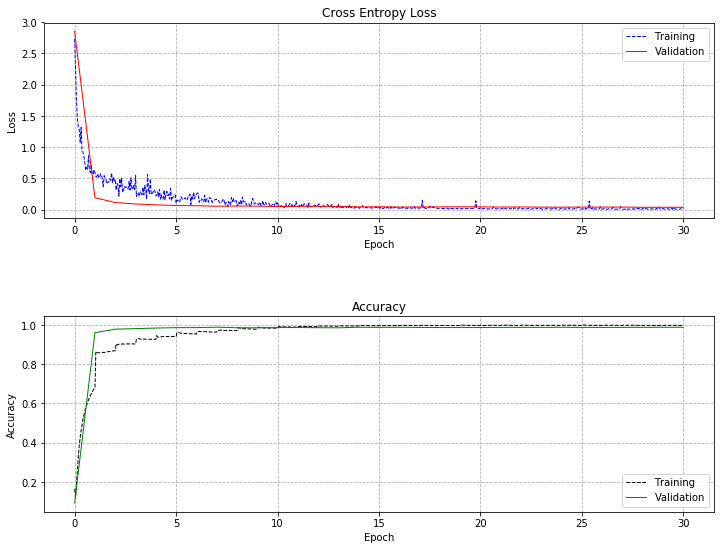

In [0]:
# define the valid steps for each epoch 
steps_per_epoch = train_generator.n // train_batch_size
val_steps = val_generator.n //  val_batch_size

# init plotting callback
plot_callback = plotCallback(steps_per_epoch)

# get the initial values
#init_train = model.evaluate_generator(train_generator,steps=2,verbose=1)
first_batch=train_generator.next()
init_train = model.evaluate(first_batch[0],first_batch[1])


init_val = model.evaluate_generator(val_generator,steps=val_steps,verbose=1)
plot_callback.set_init_values(init_train,init_val)
plot_callback.init()
# reset the training generator
train_generator.reset()

# start the training process
history = model.fit_generator(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epoch_count,callbacks=[plot_callback,cp_callback],
                              validation_data=val_generator, 
                              validation_steps=val_steps,
                              workers=2,
                              use_multiprocessing=True)
                              
# save the model
model.save(model_name)

# save the history
file = open(history_name,'w')
file.write(str(history.history))
file.close()

# save the plot
plot_callback.fig.savefig(figure_name)

### Show the final results

In [0]:
# get the validation accuracy and loss of the last epoch 
val_acc = history.history['val_acc'][-1]
val_loss = history.history['val_loss'][-1]

# show the results
print("Validation accuracy: ",val_acc)
print("Validation loss: ",val_loss)


Validation accuracy:  0.98777777
Validation loss:  0.03761264322325587
